In [116]:
import glob
import shutil
from tqdm.notebook import tqdm
import random
import pandas as pd
import numpy as np


# converting to yolo annotation
import xml.etree.ElementTree as ET
import os
import json


def xml_to_yolo(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [117]:
with open('paths.txt', 'r') as f:
    paths = [path.strip() for path in f.readlines()]

annot_list = []

for path in paths:
    path = f'{path}/train'
    ## Finding all the images and separating in training and validation
    annot_list += glob.glob(f'{path}/annotations/xmls/*.xml')


In [118]:
data = {'labels': [], 'images': []}

classes = []

for idx, file in enumerate(tqdm(annot_list)):

    basename = os.path.basename(file)
    filename = os.path.splitext(basename)[0]

    # check if the label contains the corresponding image file

    image_dir = '/'.join(file.split('/')[:4])+'/images'
    image_file = os.path.join(image_dir, filename+'.jpg')
    
    if not os.path.exists(image_file):
        print(filename, 'image does not exist!')
        continue
        
    data['labels'].append(annot_list[idx])
    data['images'].append(image_file)

  0%|          | 0/30224 [00:00<?, ?it/s]

In [119]:
for idx, file in enumerate(tqdm(data['labels'])):

    # parse the content of the xml file
    tree = ET.parse(file)
    root = tree.getroot()
    
    objects = root.findall('object')
    if objects:
        for obj in objects:
            label = obj.find("name").text
            # check for new classes and append to list
            if label not in classes:
                classes.append(label)
                data[label] = np.zeros(len(data['labels']), dtype=int)
            data[label][idx] += 1
    else:
        label = "Empty"
        if label not in classes:
            classes.append(label)
            data[label] = np.zeros(len(annot_list), dtype=int)
        data[label][idx] += 1
        
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

df

  0%|          | 0/30224 [00:00<?, ?it/s]

,labels,images,D10,D40,D00,Empty,Repair,D20,Block crack,D44,D43,D11,D01,D50,D0w0
0,./RDD2022_all_countries/China_Drone/train/anno...,./RDD2022_all_countries/China_Drone/train/imag...,0,0,0,0,0,1,0,0,0,0,0,0,0
1,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,2,0,0,0,0,0,1,0,0,0,0
2,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,1,0,2,0,0,0,0,0,0,0,0,0,0
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,1,0,0,0,0,0,3,0,0,0,0,0
4,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,0,0,0,0,0,0,0,0
30220,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,1,0,1,0,0,0,0,0,0,0,0,0,0
30221,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,2,0,0,0,1,0,0,0,0,0,0,0
30222,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,0,0,0,0,0,0,0,0


In [120]:
def plot_data(df):
    frequencies = df.mean(axis=0).sort_values()

    _ = frequencies.plot(title='Dataset for analyzing cracks', 
                         kind='barh', 
                         figsize=(12, 12),
                         color='#479EF8')

,labels,images,D10,D40,D00,Empty,Repair,D20,Block crack,D44,D43,D11,D01,D50,D0w0
0,./RDD2022_all_countries/China_Drone/train/anno...,./RDD2022_all_countries/China_Drone/train/imag...,0,0,0,0,0,1,0,0,0,0,0,0,0
1,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,2,0,0,0,0,0,1,0,0,0,0
2,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,1,0,2,0,0,0,0,0,0,0,0,0,0
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,1,0,0,0,0,0,3,0,0,0,0,0
4,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30219,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,0,0,0,0,0,0,0,0
30220,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,1,0,1,0,0,0,0,0,0,0,0,0,0
30221,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,2,0,0,0,1,0,0,0,0,0,0,0
30222,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,0,0,0,0,0,0,0,0


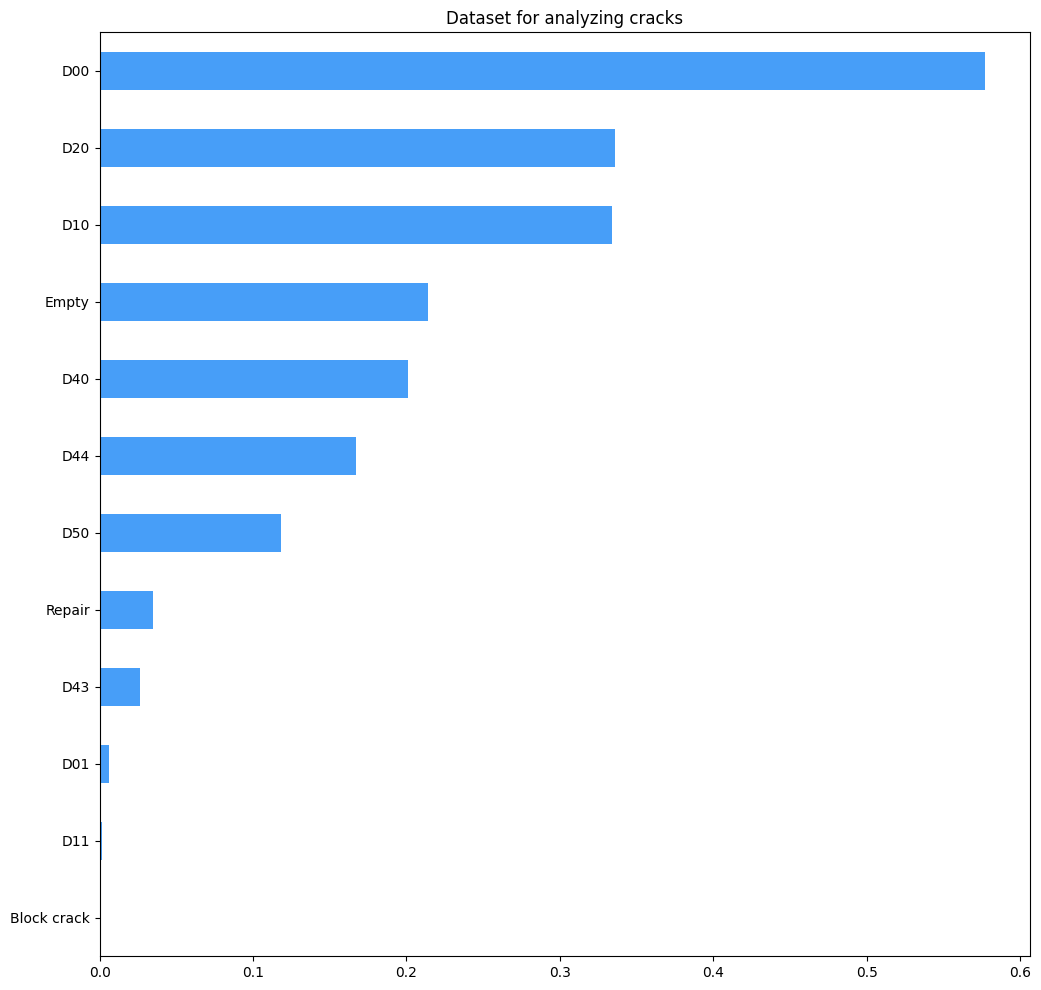

In [121]:
plot_data(df.iloc[:, 2:-1])

df

In [122]:
classes_to_drop = ['D0w0', 'Block crack', 'D11', 'D01', 'D43', 'Repair', 'D44', 'D50']

df.drop(classes_to_drop, axis=1, inplace=True)

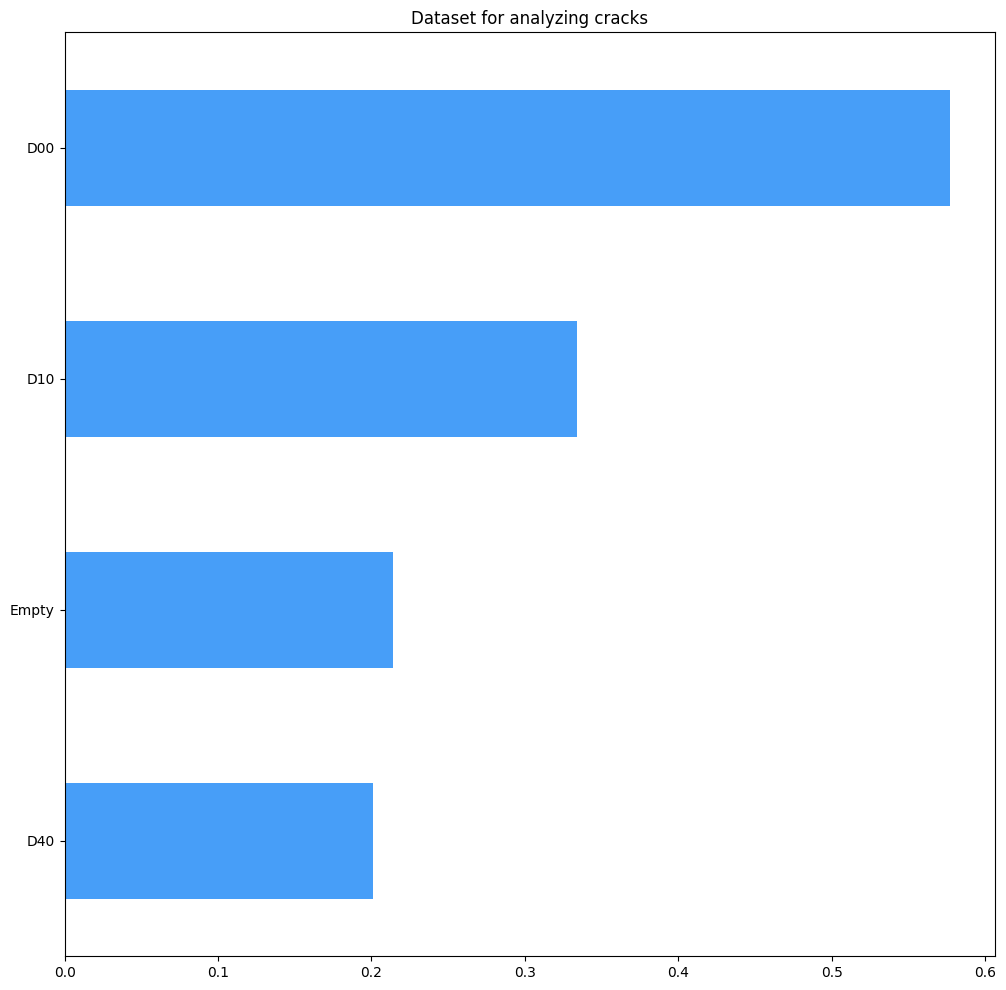

In [123]:
plot_data(df.iloc[:, 2:-1])

In [124]:
new_classes = [elem for elem in classes if elem not in classes_to_drop]
print(new_classes)

trim_df = df.loc[(df['D00'] == df[new_classes].sum(axis=1)) & (df['D00'] > 0)]

print("Shape of original dataframe:", df.shape)
#Prints shape of dataframe containing all rows where D00 exclusively is 0
print("Trimmer dataframe:", trim_df.shape)
print("Number of D00 cracks detected:", df['D00'].sum())
print("Number of D10 cracks detected:", df['D10'].sum())

['D10', 'D40', 'D00', 'Empty', 'D20']
Shape of original dataframe: (30224, 7)
Trimmer dataframe: (5751, 7)
Number of D00 cracks detected: 17446
Number of D10 cracks detected: 10100


In [125]:
trim_df = trim_df.sort_values(by=['D00'], ascending=False)
trim_df = trim_df.iloc[:3600, :]
print("Number of D00 detections in trimmer_df:", trim_df['D00'].sum())


trim_df

Number of D00 detections in trimmer_df: 6661


,labels,images,D10,D40,D00,Empty,D20
16639,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,9,0,0
21849,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,9,0,0
26313,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,0,7,0,0
10193,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,7,0,0
27518,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,7,0,0
...,...,...,...,...,...,...,...
1428,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0
26827,./RDD2022_all_countries/China_MotorBike/train/...,./RDD2022_all_countries/China_MotorBike/train/...,0,0,1,0,0
26906,./RDD2022_all_countries/China_Drone/train/anno...,./RDD2022_all_countries/China_Drone/train/imag...,0,0,1,0,0
1410,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,1,0,0


In [126]:
cond = df['labels'].isin(trim_df['labels'])
df.drop(df[cond].index, inplace = True)

df.reset_index(drop=True, inplace=True)

print(df.shape)

(26624, 7)


Number of D00 detections after processing: 10785


/var/folders/k6/t__53lhj7j59kljh21yj7r8m0000gn/T/ipykernel_48759/293938576.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  frequencies = df.mean(axis=0).sort_values()


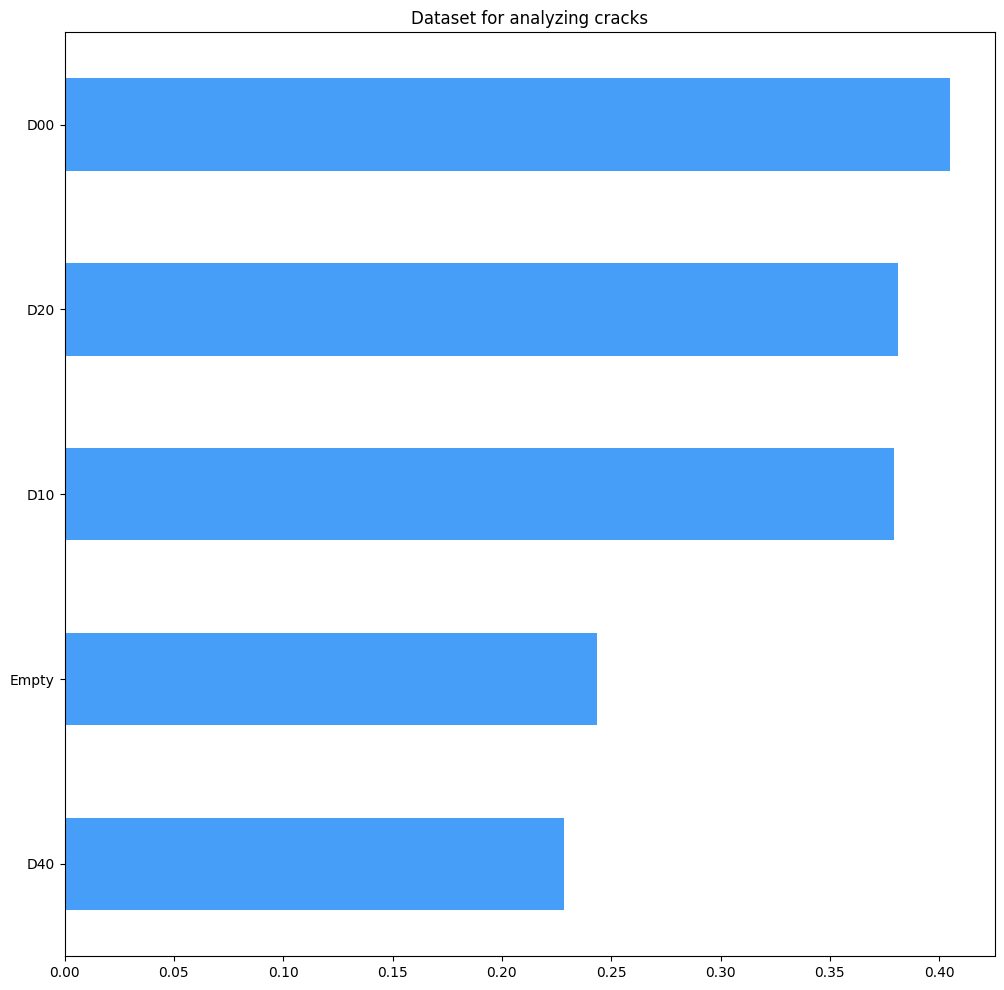

In [127]:
plot_data(df[2:-1])

print("Number of D00 detections after processing:", df['D00'].sum())

In [128]:
#Removing rows where there are no detectinos
print("Shape of dataframe before removing 'zero rows'", df.shape)
df = df.loc[df[new_classes].sum(axis=1) != 0]
df.reset_index(drop=True, inplace=True)
print("Shape of dataframe after removing 'zero rows'", df.shape)

Shape of dataframe before removing 'zero rows' (26624, 7)
Shape of dataframe after removing 'zero rows' (23730, 7)


In [129]:
import numpy as np

split_data = []

for idx, row in tqdm(df.iterrows()):
    if idx <= df.shape[0]*0.75:
        split_data.append('train')
    else:
        split_data.append('val')

print(df.shape)

print(len(split_data))
        
df['split'] = split_data

df.reset_index(drop=True, inplace=True)

0it [00:00, ?it/s]

(23730, 7)
23730


/var/folders/k6/t__53lhj7j59kljh21yj7r8m0000gn/T/ipykernel_48759/2200552693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['split'] = split_data


In [130]:
df.to_csv('training_data.csv')

df

,labels,images,D10,D40,D00,Empty,D20,split
0,./RDD2022_all_countries/China_Drone/train/anno...,./RDD2022_all_countries/China_Drone/train/imag...,0,0,0,0,1,train
1,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,1,0,2,0,0,train
2,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,1,0,0,0,train
3,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,0,1,0,0,train
4,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,1,0,0,0,train
...,...,...,...,...,...,...,...,...
23725,./RDD2022_all_countries/India/train/annotation...,./RDD2022_all_countries/India/train/images/Ind...,0,0,0,0,1,val
23726,./RDD2022_all_countries/Czech/train/annotation...,./RDD2022_all_countries/Czech/train/images/Cze...,1,0,1,0,0,val
23727,./RDD2022_all_countries/Japan/train/annotation...,./RDD2022_all_countries/Japan/train/images/Jap...,0,2,0,0,1,val
23728,./RDD2022_all_countries/United_States/train/an...,./RDD2022_all_countries/United_States/train/im...,0,0,1,0,0,val


In [132]:
os.makedirs('./dataset/train/images')
os.makedirs('./dataset/train/labels')
os.makedirs('./dataset/val/images')
os.makedirs('./dataset/val/labels')

In [133]:
for idx, row in tqdm(df.iterrows()):
    
    annotation = row['labels']
    image = row['images']
    
    result = []

    # parse the content of the xml file
    tree = ET.parse(annotation)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    
    objects = root.findall('object')
    if objects:
        for obj in objects:
            label = obj.find("name").text
            if label in classes_to_drop:
                continue
            index = new_classes.index(label)
            pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
            yolo_bbox = xml_to_yolo(pil_bbox, width, height)
            # convert data to string
            bbox_string = " ".join([str(x) for x in yolo_bbox])
            result.append(f"{index} {bbox_string}")
    else:
        result.append('')
        

    if result:
        if row['split'] == 'train':
            dest = 'dataset/train'
        else:
            dest = 'dataset/val'
        
        
        # generate a YOLO format text file for each xml file
        with open(dest+'/labels/'+str(idx).zfill(6)+'.txt', 'w') as f:
            f.write('\n'.join(result))
            
        # moving images
        shutil.copy(
            image,
            dest+'/images/'+str(idx).zfill(6)+'.jpg'
        )
        
# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(new_classes))

0it [00:00, ?it/s]

In [134]:
import cv2
import matplotlib.pyplot as plt

def plot_bounding_box(image_path):
    img = cv2.imread(image_path)
    dh, dw, _ = img.shape

    split_string = image_path.split('/')
    

    
    label_path = '/'.join((split_string[:2]))+'/labels/'+split_string[3].split('.')[0]+'.txt'
    fl = open(label_path, 'r')
    data = fl.readlines()
    fl.close()

    for dt in data:

        # Split string to float
        _, x, y, w, h = map(float, dt.split(' '))

        # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0:
            l = 0
        if r > dw - 1:
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1

        cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

    plt.imshow(img)
    plt.show()



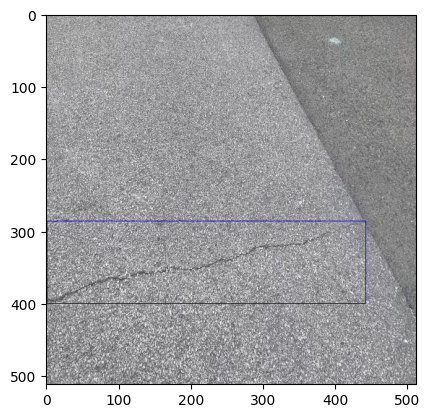

In [135]:
plot_bounding_box('dataset/train/images/000015.jpg')

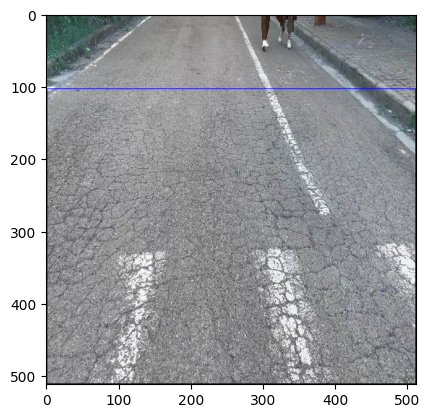

In [159]:
plot_bounding_box('dataset/train/images/017232.jpg')

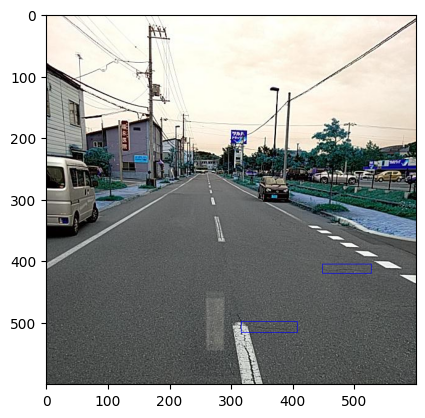

In [152]:
plot_bounding_box('dataset/train/images/012318.jpg')